In [3]:
import os
import pandas as pd
import itertools
from matplotlib import pyplot as plt
import numpy as np

# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image

from keras.applications import VGG16

from keras.preprocessing.image import ImageDataGenerator

# from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# from tqdm import tqdm

import time

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4735723597558359844
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 223220432064129239
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [6]:
# from torchvision import transforms

In [7]:
from random_eraser import get_random_eraser  # added
from mixup_generator import MixupGenerator
from mixupimagedatagenerator import MixupImageDataGenerator

In [9]:
# from collections import Counter
# import cv2
# from PIL import Image, ImageFilter, ImageOps

In [8]:
import torch
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'GeForce GTX 1060 with Max-Q Design'

# Trying out GPU usage

## Open files

In [9]:
train = pd.read_csv('train.csv', dtype = {'category':'str'})

In [10]:
os.chdir('Shopee-product-detection-dataset')

In [11]:
train['filename'] = train.category + r'\\' + train.filename

In [12]:
train_10 = pd.concat([train[train.category==i].sample(250) for i in train.category.unique()])
train_20 = pd.concat([train[train.category==i].sample(500) for i in train.category.unique()])

In [13]:
train.head()

filename category
0  03\\45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg       03
1  03\\f74d1a5fc2498bbbfa045c74e3cc333e.jpg       03
2  03\\f6c172096818c5fab10ecae722840798.jpg       03
3  03\\251ffd610399ac00fea7709c642676ee.jpg       03
4  03\\73c7328b8eda399199fdedec6e4badaf.jpg       03

Mixup in Keras
- https://github.com/yu4u/mixup-generator
- https://www.dlology.com/blog/how-to-do-mixup-training-from-image-files-in-keras/

In [14]:
batch_size = 128

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, 
                                   brightness_range=[0.2,1.0],
                                   preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                                    fill_mode='nearest',)


In [15]:
path = 'D:\\Shopee\\Open Round 2_Product Detection\\Shopee-product-detection-dataset\\train'

In [16]:
train_generator = MixupImageDataGenerator(generator=train_datagen,
                                          directory= path,
                                          batch_size=batch_size,
                                          img_height=100,
                                          img_width=100,
                                          subset='training')

Found 84329 images belonging to 42 classes.
Found 84329 images belonging to 42 classes.


In [17]:
validation_generator = train_datagen.flow_from_directory(path,
                                                       target_size=(100, 100),
                                                       class_mode="categorical",
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       subset='validation')

Found 21061 images belonging to 42 classes.


In [19]:
?image.array_to_img

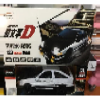

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.65651083e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [21]:
sample_x, sample_y = next(train_generator)
for i in range(1):
    display(image.array_to_img(sample_x[i]))
print(sample_y)

In [13]:
# #to just select a sample
# train_generator = train_datagen.flow_from_dataframe(dataframe = train_10, 
#                                                     directory = "train", 
#                                                     x_col = "filename", 
#                                                     y_col = "category", 
#                                                     class_mode = "categorical", 
#                                                     target_size = (32,32), 
#                                                     batch_size = batch_size)

Found 10498 validated image filenames belonging to 42 classes.


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Base model

In [14]:
#2 convolutional layers, one dense hidden layer and an output layer
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(32,32,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(42, activation='softmax'))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/t

In [15]:
#compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [16]:
%%time 
history = model.fit_generator(
        train_generator, 
        steps_per_epoch=int(105392 /batch_size),  
        epochs=1,
        verbose=1)

Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 1/1
Executing op __inference_keras_scratch_graph_1314 in device /job:localhost/replica:0/task:0/device:GPU:0
  7/823 [..............................] - ETA: 3:51:34 - loss: 3.7673 - accuracy: 0.0201

KeyboardInterrupt: 

# Class imbalance

- imbalanced dataset
    - image augmentation
- noisy dataset

In [33]:
sum([len(i) for i in filename_train])

105398

<BarContainer object of 42 artists>

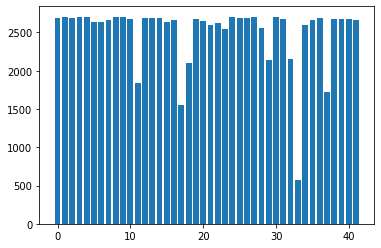

In [34]:
plt.bar(np.arange(42), [len(i) for i in filename_train])

In [51]:
# sample = {}
# train_image = []
# y = []

# for i in os.listdir():
#     start = time.time()
#     files = np.random.choice(os.listdir(i), 100)
#     for photo in files:
# #         img = cv2.cvtColor(cv2.imread("{}\\{}".format(i, photo)), cv2.COLOR_BGR2RGB)
#         try:
#             img = image.load_img("{}\\{}".format(i, photo), target_size=(32,32,1), grayscale=False)
#             img = image.img_to_array(img)
#             img = img/255
#             train_image.append(img)
#             y.append(i)
#         except:
#             continue
# #     print("Done: {} - Time: {}".format(i, time.time()-start))
    
# X = np.array(train_image)
# y = to_categorical(y) #one hot encoding

# #create validation set
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

Done: 00 - Time: 4.66554856300354
Done: 01 - Time: 4.126392602920532
Done: 02 - Time: 4.571221113204956
Done: 03 - Time: 4.415172576904297
Done: 04 - Time: 3.864084243774414
Done: 05 - Time: 3.1245052814483643
Done: 06 - Time: 3.739978551864624
Done: 07 - Time: 3.2671279907226562
Done: 08 - Time: 3.6995699405670166
Done: 09 - Time: 3.533883571624756
Done: 10 - Time: 3.756180763244629
Done: 11 - Time: 3.273231029510498
Done: 12 - Time: 3.8498423099517822
Done: 13 - Time: 3.3155102729797363
Done: 14 - Time: 3.3456385135650635
Done: 15 - Time: 3.30804705619812
Done: 16 - Time: 3.809218406677246
Done: 17 - Time: 2.5806188583374023
Done: 18 - Time: 2.833181381225586
Done: 19 - Time: 3.418682813644409
Done: 20 - Time: 3.6111459732055664
Done: 21 - Time: 3.5902671813964844
Done: 22 - Time: 4.015994548797607
Done: 23 - Time: 3.2961843013763428
Done: 24 - Time: 3.490449905395508
Done: 25 - Time: 4.266238212585449
Done: 26 - Time: 3.7845747470855713
Done: 27 - Time: 3.6035709381103516
Done: 28 -

# Transfer Learning using Keras
https://medium.com/@sagarsonwane230797/transfer-learning-from-pre-trained-model-for-image-facial-recognition-8b0c2038d5f0

Keras applications
https://keras.io/api/applications/

## VGG16

In [29]:
model = VGG16(include_top = False, 
              weights = 'imagenet', 
             input_shape = (100,100,3))
model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ran

In [14]:
for (i, layer) in enumerate(model.layers):
    print(str(i), layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


## Inception V3

In [22]:
from keras.applications.inception_v3 import InceptionV3

In [24]:
model = InceptionV3(include_top = False, 
                    weights = 'imagenet', 
                    input_shape = (100,100,3))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ran

## Xception

In [27]:
from keras.applications.xception import Xception
model = Xception(include_top = False)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp

## ResNet50

In [28]:
from keras.applications.resnet50 import ResNet50
# load model
model = ResNet50(include_top = False)

Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Exec

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 177s 2us/step


## EfficientNetB4

In [16]:
from tensorflow.python.keras.applications.efficientnet import EfficientNetB4

ModuleNotFoundError: No module named 'tensorflow.python.keras.applications.efficientnet'

In [18]:
from keras.applications.efficientnet import EfficientNetB4

ModuleNotFoundError: No module named 'keras.applications.efficientnet'

In [17]:
print(tf.__version__)

2.1.0


In [78]:
model = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape = (100,100,3),
    pooling=None,
    classes=42,
    classifier_activation="softmax",
)

AttributeError: module 'tensorflow_core.keras.applications' has no attribute 'EfficientNetB4'

## InceptionResNetV2

In [33]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [34]:
model = InceptionResNetV2(include_top = False,
                         weights = 'imagenet')

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Rando

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomU

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUnifo

In [36]:
from keras.applications.nasnet import NASNetLarge

In [37]:
model = NASNetLarge(include_top = False,
                         weights = 'imagenet')

Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandle

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUni

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ran

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ran

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op

## Training the model from pretrained models

In [25]:
for layer in model.layers:
    layer.trainable = False

In [26]:
for (i, layer) in enumerate(model.layers):
    print(str(i), layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 Conv2D False
46 BatchNormalization False
47 Batc

In [27]:
model.input

<tf.Tensor 'input_2:0' shape=(None, 100, 100, 3) dtype=float32>

In [28]:
def addTopModel(bottom_model, num_classes, D=256):
    top_model = bottom_model.output
    top_model = Flatten()(top_model)
    top_model = Dense(512, activation = 'relu')(top_model)
    top_model = Dense(512, activation = 'relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(42, activation = 'softmax')(top_model)
    return top_model

In [29]:
FC_Head = addTopModel(model, 42)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [30]:
from keras.models import Model

In [31]:
my_model = Model(inputs = model.input, outputs=FC_Head)
my_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 49, 49, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 49, 49, 32)   0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [32]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [33]:
lr = 30e-5
def scheduler(epoch, lr):
    if epoch <=25:
        return lr
    elif epoch > 25:
        return 15e-5
    elif epoch > 30:
        return 7.5e-5
    elif epoch > 35:
        return 3e-5
    elif epoch > 40:
        return 1e-5

In [34]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [35]:
checkpoint = ModelCheckpoint("VGG16.h5",
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1)
earlystop = EarlyStopping(monitor = 'val_loss',
                         min_delta = 0, 
                         patience = 3,
                         verbose = 1, 
                         restore_best_weights = True)

In [37]:
#compile model
my_model.compile(loss='categorical_crossentropy',
              optimizer='Adam', 
              metrics=['accuracy'])

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#train model
classifier = my_model.fit_generator(train_generator,
                                    epochs=1, 
                                    steps_per_epoch = 84329 // batch_size,
                                    callbacks = [callback],
                                    validation_data = validation_generator,
                                   validation_steps = 21000 // batch_size,
                                   use_multiprocessing = True)

my_model.save("InceptionV3.h5")

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 1/1
Executing op __inference_keras_scratch_graph_32705 in device /job:localhost/replica:0/task:0/device:GPU:0
 66/658 [==>...........................] - ETA: 2:03:56 - loss: 3.7504 - accuracy: 0.0309

KeyboardInterrupt: 

In [ ]:
from keras_efficientnets import EfficientNet, BlockArgs

# Fastai

In [43]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastai.metrics import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta

ModuleNotFoundError: No module named 'fastai'

In [41]:
from efficientnet_pytorch import EfficientNet

In [7]:
# from efficientnet import EfficientNetB3

In [38]:
import torch

In [39]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060 with Max-Q Design'

## EfficientNet + Cutout

https://www.kaggle.com/ateplyuk/inat2019-starter-keras-efficientnet

In [42]:
model = EfficientNet.from_pretrained('efficientnet-b3')

Loaded pretrained weights for efficientnet-b3


In [11]:
learn = Learner(data,getModel(False),
                metrics=[error_rate],
                model_dir='/kaggle/working',
                loss_func=LabelSmoothingCrossEntropy()).mixup().to_fp16()

NameError: name 'data' is not defined

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3,1e-3)

In [ ]:
SZ=224
cutout_frac = 0.25
p_cutout = 0.75
cutout_sz = round(SZ*cutout_frac)
cutout_tfm = cutout(n_holes=(1,1), length=(cutout_sz, cutout_sz), p=p_cutout)

In [2]:
os.getcwd()

'D:\\Shopee\\Open Round 2'

In [24]:
train.head()

filename  category
0  45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg         3
1  f74d1a5fc2498bbbfa045c74e3cc333e.jpg         3
2  f6c172096818c5fab10ecae722840798.jpg         3
3  251ffd610399ac00fea7709c642676ee.jpg         3
4  73c7328b8eda399199fdedec6e4badaf.jpg         3

In [62]:
from torch.utils.data.sampler import WeightedRandomSampler

## Class imbalance

Weighted Random Sampler
https://medium.com/analytics-vidhya/augment-your-data-easily-with-pytorch-313f5808fc8b
https://www.kaggle.com/tanlikesmath/oversampling-mnist-with-fastai#Creating-imbalanced-dataset - codes for implementation

Stratified Sampler
https://medium.com/@champs.jaideep/stratified-batch-sampler-using-fastai-20f9b898609d

Imbalanced Data Sampler
https://github.com/ufoym/imbalanced-dataset-sampler
- rebalance the class distributions when sampling from the imbalanced dataset
- estimate the sampling weights automatically
- avoid creating a new balanced dataset
- mitigate overfitting when it is used in conjunction with data augmentation techniques


READ TOMORROW: https://discuss.pytorch.org/t/dealing-with-imbalanced-datasets-in-pytorch/22596/36
https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/32

## Data augmentation

https://docs.fast.ai/vision.transform.html
https://medium.com/@pierre_guillou/data-augmentation-by-fastai-v1-84ca04bea302

In [13]:
data = ImageDataBunch.from_folder('D:\\Shopee\\Open Round 2_Product Detection\\Shopee-product-detection-dataset', 
                                  train = 'train', 
                                  test = 'test',
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
path = 'D:\\Shopee\\Open Round 2\\Shopee-product-detection-dataset'

In [10]:
# data = (ImageList.from_folder(path+'\\train')
#              .split_by_rand_pct()
#              .label_from_folder()
#              .add_test_folder(path+'\\test')
#              .databunch(path=path))

You can deactivate this warning by passing `no_check=True`.


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\fastai\basic_data.py:272: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([3, 594, 594]), torch.Size([3, 666, 666]), torch.Size([3, 800, 800]), torch.Size([3, 700, 700]), torch.Size([3, 400, 400]), torch.Size([3, 750, 750]), torch.Size([3, 700, 700]), torch.Size([3, 654, 654]), torch.Size([3, 700, 700]), torch.Size([3, 800, 800]), torch.Size([3, 933, 933]), torch.Size([3, 947, 947]), torch.Size([3, 606, 606]), torch.Size([3, 640, 640]), torch.Size([3, 1024, 1024]), torch.Size([3, 640, 640]), torch.Size([3, 1001, 1001]), torch.Size([3, 540, 540]), torch.Size([3, 422, 422]), torch.Size([3, 800, 800]), torch.Size([3, 400, 400]), torch.Size([3, 610, 610]), torch.Size([3, 556, 556]), torch.Size([3, 684, 684]), torch.Size([3, 800, 800]), torch.Size([3, 905, 905]), torch.Size([3, 320, 320]), torch.Size([3, 500, 500]), torch.Size([3, 966, 966]), torch

In [14]:
data

ImageDataBunch;

Train: LabelList (84312 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
00,00,00,00,00
Path: D:\Shopee\Open Round 2_Product Detection\Shopee-product-detection-dataset;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
19,24,19,24,04
Path: D:\Shopee\Open Round 2_Product Detection\Shopee-product-detection-dataset;

Test: LabelList (12192 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: D:\Shopee\Open Round 2_Product Detection\Shopee-product-detection-dataset

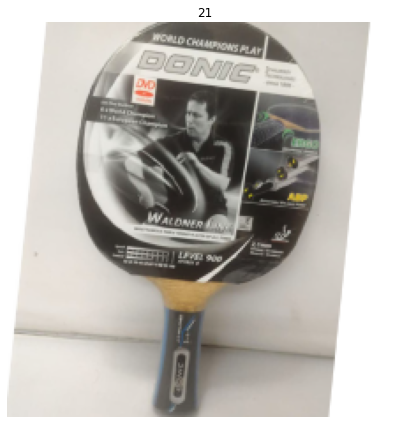

In [15]:
data.show_batch(rows=1, figsize=(7,6))

To normalize the data in our object, we simply call normalize() on the object. It is possible to use ImageNet, CIFAR or MNIST stats as templates here, and if left empty this function will simply grab a batch of data from our object and compute the stats on it (mean and standard-deviation) and normalize the data accordingly. Since we will be using a ResNet architecture for our model which was trained on ImageNet, we will be using the ImageNet stats.

In [14]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 871, 871),Image (3, 800, 800),Image (3, 400, 400),Image (3, 800, 800),Image (3, 1024, 1024)
y: CategoryList
00,00,00,00,00
Path: D:\Shopee\Open Round 2\Shopee-product-detection-dataset\train;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 700, 700),Image (3, 800, 800),Image (3, 511, 511),Image (3, 800, 800),Image (3, 800, 800)
y: CategoryList
07,03,01,11,23
Path: D:\Shopee\Open Round 2\Shopee-product-detection-dataset\train;

Test: LabelList (12192 items)
x: ImageList
Image (3, 700, 700),Image (3, 581, 581),Image (3, 533, 533),Image (3, 660, 660),Image (3, 800, 800)
y: EmptyLabelList
,,,,
Path: D:\Shopee\Open Round 2\Shopee-product-detection-dataset\train

Fastai supplies us with a function called create_cnn() from its vision module. This function creates what is called a learner object, which we'll put into a properly named variable. See here that we specify the ResNet architecture as our base model for transfer learning. Upon call, the trained architecture will be downloaded via the Fastai API and stored locally.

In [16]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy], callback_fns=ShowGraph)

## Mixup 

The main advantage of using mixup is that it can be implemented in a few lines of code, with hardly any computational overhead. What mixup does is, it forces your neural network to favor simple linear behavior in-between your classes. It makes your neural network more robust against adversarial samples and helps it regularize well.
In fastai, using mixup is as simple as doing:

In [16]:
learner = Learner(data, model, metrics=[accuracy]).mixup()

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(8, max_lr=slice(1e-3, 1e-2))

Let’s see where the algorithm is making the most mistakes:


In [ ]:
interpreter = ClassificationInterpretation.from_learner(learner)
interpreter.most_confused(min_val=2)

Unfreezing and fine-tuning


Before we unfreeze the layers and learn again, we save the weights so that we can go back in case we mess up.

In [ ]:
learner.save(‘stage-1’)
#learner.load(‘stage-1’)
learner.unfreeze()
learner.fit_one_cycle(12, max_lr=slice(1e-5, 1e-4))

# Try tomorrow
- ResNet50
- Data Augmentation - stretching, etc.
- Try out different parameters
- Follow steps on the paper with imbalanced dataset

- DONE: read more on this https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/78109
- https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(10, activation='softmax')
])

ImportError: cannot import name 'Conv2'